### Notebook for analysing nf pipeline output

#### Sequencing batch 9

### Sequencing information 
 - Analysis no.: A003-service
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext FS and NEBNext
 - Seq Date: 30-04-2021
 - Number of samples:76

In [1]:
base_dir = '/home/douso/Kibet/2021-04-30_run6_KEMRI'

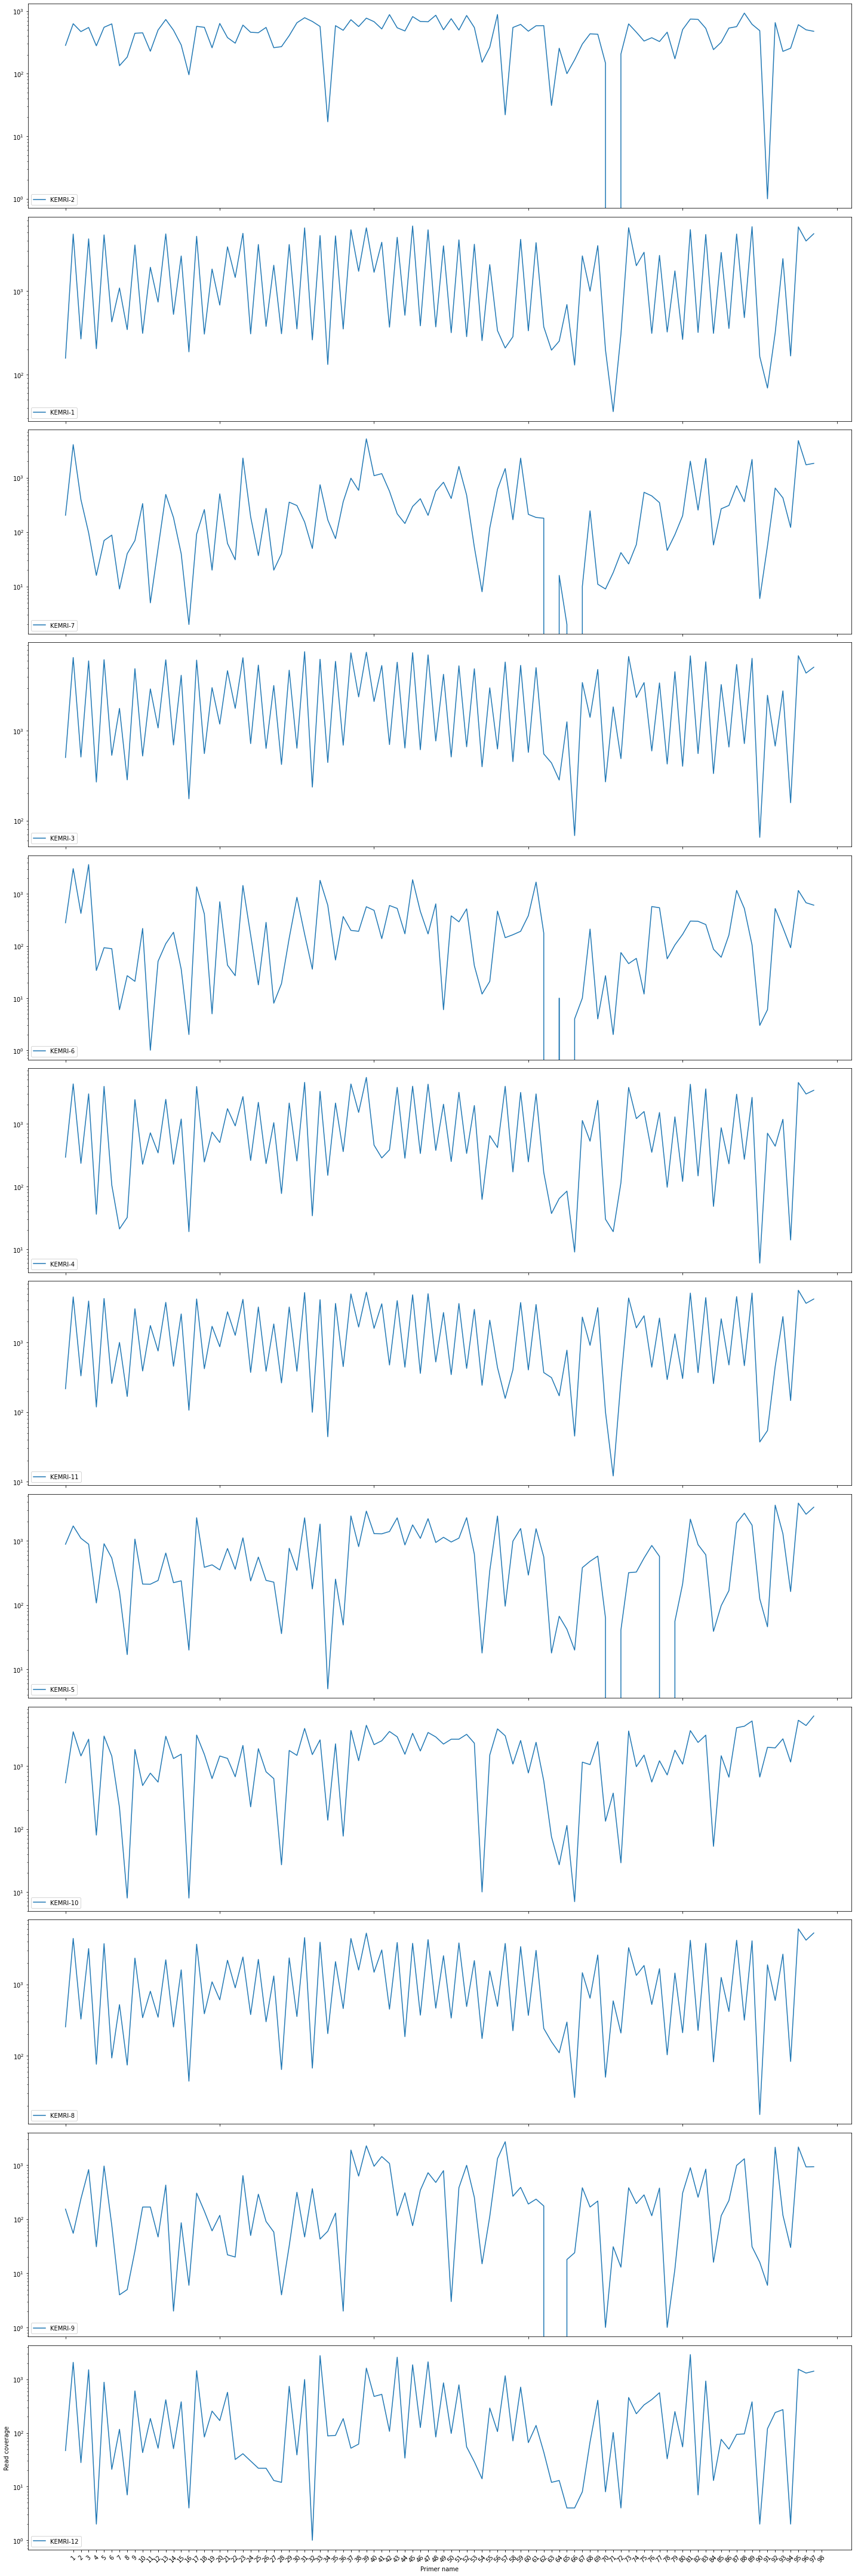

In [2]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.amplicon.regions.coverage.tsv'
files = os.listdir(f'{base_dir}/dpt')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1
fig, axs = plt.subplots(a, b, figsize=(20,60)) 

xtick = np.arange(1, 99)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    sample_df = pd.read_table(f'{base_dir}/dpt/{file}')
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='lower left')
plt.xlabel('Primer name')
plt.ylabel('Read coverage')
plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savesample_df2fig('avg_kit_coverage2.png')


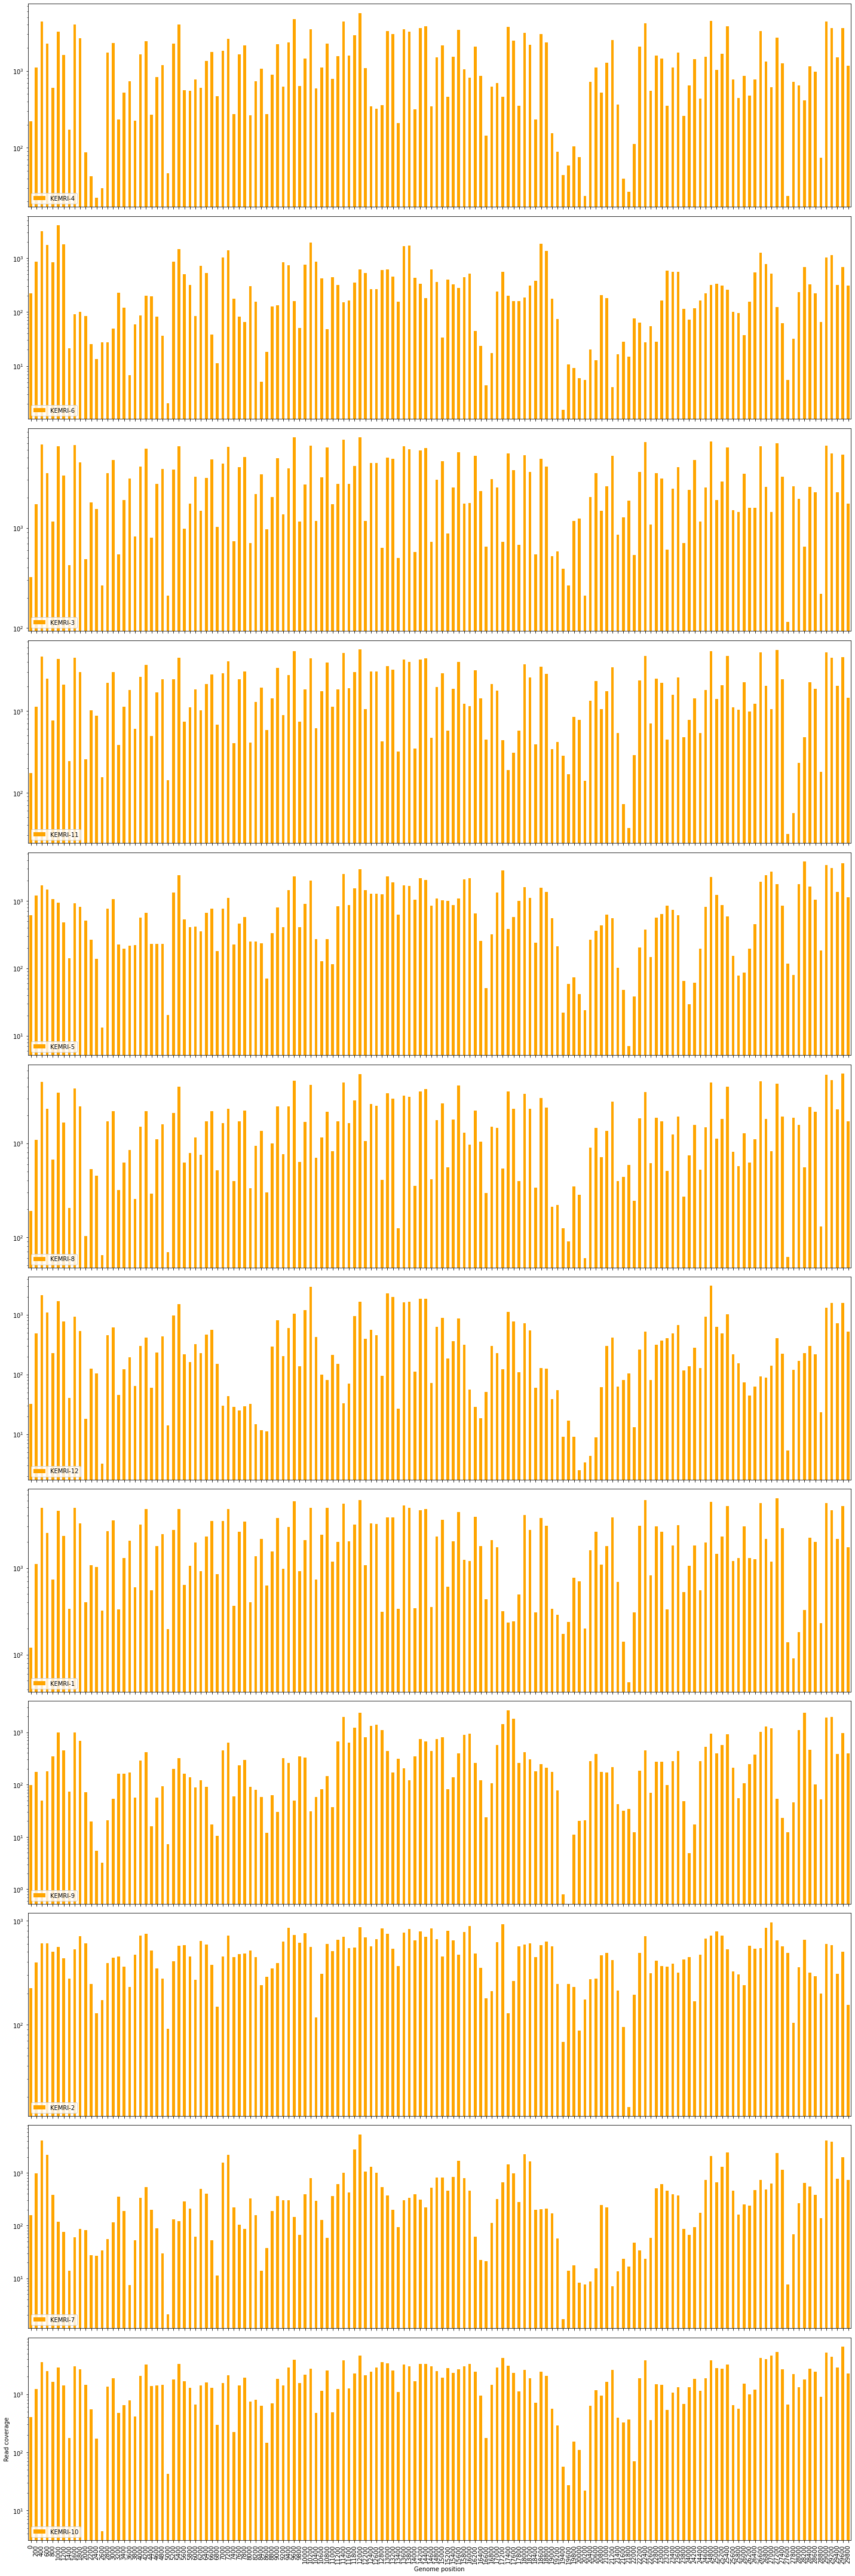

In [3]:
# plot read depths-GK
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt

suffix = '.genome.regions.coverage.tsv'
files = os.listdir(f'{base_dir}/dpt')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fig, axs = plt.subplots(a, b, figsize=(20, 60))

xtick = range(0, 30000, 500)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    try:
        df1 = pd.read_table(f'{base_dir}/dpt/{file}')
        d = df1['coverage'].to_frame()
        d.set_index(np.arange(0, 30000, 200)).plot.bar(logy=True, ax=axs[c], sharex=True, color='orange')
        axs[c].legend([sample_name], loc='lower left')
        text = file.split('_')[1]
        plt.ylabel('Read coverage')
    except TypeError:
            print(f'no numeric data to plot for {file}')
    finally: pass
plt.xlabel('Genome position')
# plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savefig('avg_kit_coverage.png')

## Packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import glob, os

In [5]:
# base_dir = '/home/douso/Kibet/2021-04-30_run6_KEM'
batch = 'seq9'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

## Analysis of batch 8
### Sequencing information 
 - Analysis no.: NF-002-service (batch 8)
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext (FS and non-FS)
 - Seq Date: MiSeq (30-04-2021)
 - Number of samples: 12
 - Sample summ: KEMRI
 - VC pipeline: nextflow-viralcon

## Functions

In [6]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [7]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [8]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [9]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [10]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [11]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.merge(df_cts_cln, left_on='Sample_No', right_on='Sample_Name')
            .drop('Sample_Name', axis=1))


In [12]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('Sequence_name')
            .merge(df_rmdCts.set_index('Sample_number'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'Sequence_name'}))

In [13]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0]))
    return df_fnl

### Variants data

In [14]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/k-per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.split('_')[0]))

In [15]:
df_var_fnl.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,KEMRI-10,18,"L61L, E102Q, T265I, L628F, F924F, D1585N, D158...",NaN,D614G,Q57H,NaN,NaN,NaN,NaN,NaN,NaN,"G66_K68delinsE, K68*","P13S, A35V, R195K, P207T",NaN,NaN,NaN
1,KEMRI-8,16,"S216S, T265I, N615N, F924F, T1001I, T4164I, Q4...",NaN,"D614G, S982A",Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"S186F, R195K",NaN,NaN,NaN
2,KEMRI-12,39,"S216S, L730F, F924F, T1001I, L1490I, A1708D, F...",NaN,"H69_V70del, D138H, Y145del, G447G, Y449H, Y449...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Q27*, R52I, Y73C","D3H, D3V, D3E, P13S, A35V",NaN,NaN,NaN
3,KEMRI-6,41,"E102Q, S216S, H236Y, N615N, L766L, F924F, T100...",NaN,"Q52E, Y145del, A570D, D614G, A701V, S982A, D1118H",S171L,NaN,NaN,NaN,NaN,NaN,NaN,Y73C,"D3H, D3V, D3E, T135I, R195K, R203K, R203R, G20...",NaN,NaN,NaN
4,KEMRI-1,26,"N1436N, S2839S, I2961I, T2967T, N3494N, M3655I...",NaN,"L18F, R102I, H146H, F157L, V367F, Q613H, P681R,",Q57H,NaN,NaN,C86F,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN


### Nextclade data

In [16]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/run6_KEMRI_con.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.split('_')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

In [17]:
df_nxt_fnl.head()

,seqName,clade,coverage
0,KEMRI-10,20C,95.3
1,KEMRI-11,19B,98.9
2,KEMRI-12,20B,83.1
3,KEMRI-1,19B,99.9
4,KEMRI-2,19B,97.2


### Pangolin data v.2.4.2 (25-04-2021)

In [18]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/run6_KEMRI_con.pangolin.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_cln1 = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))
df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months)))

In [19]:
df_png_fnl.head()

,Sequence_name,Lineage,Date_range,Most_common_countries
0,KEMRI-10,B.1,"Jan-24, Apr-13","USA, UK, Spain"
1,KEMRI-11,A.23.1,"Oct-21, Feb-12","UK, Uganda, Canada"
2,KEMRI-12,B.1.1.7,"Sep-20, Feb-21","UK, Denmark, France"
3,KEMRI-1,A.23.1,"Oct-21, Feb-12","UK, Uganda, Canada"
4,KEMRI-2,A.23.1,"Oct-21, Feb-12","UK, Uganda, Canada"


# Metadata

### Combining data

#### Merge Variants and Nextclade data

In [23]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [24]:
df_varNxt.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,KEMRI-1,26,"N1436N, S2839S, I2961I, T2967T, N3494N, M3655I...",NaN,"L18F, R102I, H146H, F157L, V367F, Q613H, P681R,",Q57H,NaN,NaN,C86F,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN,19B,99.9
1,KEMRI-10,18,"L61L, E102Q, T265I, L628F, F924F, D1585N, D158...",NaN,D614G,Q57H,NaN,NaN,NaN,NaN,NaN,NaN,"G66_K68delinsE, K68*","P13S, A35V, R195K, P207T",NaN,NaN,NaN,20C,95.3
2,KEMRI-11,26,"N1436N, S2839S, I2961I, T2967T, N3494N, M3655I...",NaN,"L18F, H146H, F157L, V367F, Q613H, P681R, A845A,",Q57H,NaN,NaN,C86F,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN,19B,98.9
3,KEMRI-12,39,"S216S, L730F, F924F, T1001I, L1490I, A1708D, F...",NaN,"H69_V70del, D138H, Y145del, G447G, Y449H, Y449...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Q27*, R52I, Y73C","D3H, D3V, D3E, P13S, A35V",NaN,NaN,NaN,20B,83.1
4,KEMRI-2,27,"N1436N, V1750L, S2839S, I2961I, T2967T, N3494N...",NaN,"L18F, H146H, F157L, V367F, Q613H, P681R, A845A,",Q57H,NaN,NaN,C86F,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN,19B,97.2


#### Merge pango and var-nextclade data

In [25]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [26]:
df_pngVxt.head()

,Sequence_name,Lineage,Date_range,Most_common_countries,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,KEMRI-1,A.23.1,"Oct-21, Feb-12","UK, Uganda, Canada",26,"N1436N, S2839S, I2961I, T2967T, N3494N, M3655I...",NaN,"L18F, R102I, H146H, F157L, V367F, Q613H, P681R,",Q57H,NaN,...,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN,19B,99.9
1,KEMRI-10,B.1,"Jan-24, Apr-13","USA, UK, Spain",18,"L61L, E102Q, T265I, L628F, F924F, D1585N, D158...",NaN,D614G,Q57H,NaN,...,NaN,NaN,NaN,"G66_K68delinsE, K68*","P13S, A35V, R195K, P207T",NaN,NaN,NaN,20C,95.3
2,KEMRI-11,A.23.1,"Oct-21, Feb-12","UK, Uganda, Canada",26,"N1436N, S2839S, I2961I, T2967T, N3494N, M3655I...",NaN,"L18F, H146H, F157L, V367F, Q613H, P681R, A845A,",Q57H,NaN,...,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN,19B,98.9
3,KEMRI-12,B.1.1.7,"Sep-20, Feb-21","UK, Denmark, France",39,"S216S, L730F, F924F, T1001I, L1490I, A1708D, F...",NaN,"H69_V70del, D138H, Y145del, G447G, Y449H, Y449...",NaN,NaN,...,NaN,NaN,NaN,"Q27*, R52I, Y73C","D3H, D3V, D3E, P13S, A35V",NaN,NaN,NaN,20B,83.1
4,KEMRI-2,A.23.1,"Oct-21, Feb-12","UK, Uganda, Canada",27,"N1436N, V1750L, S2839S, I2961I, T2967T, N3494N...",NaN,"L18F, H146H, F157L, V367F, Q613H, P681R, A845A,",Q57H,NaN,...,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN,19B,97.2


In [27]:
df = pd.DataFrame(columns=['S_NUM', 'AGE', 'AGE_UNIT', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct'])

In [28]:
df_snum = df.assign(S_NUM=df_pngVxt['Sequence_name'])

In [29]:
df_snum.head()

,S_NUM,AGE,AGE_UNIT,GEND,OCCU,NAT,COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,AVG_Ct
0,KEMRI-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KEMRI-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KEMRI-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KEMRI-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KEMRI-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_vnpPmd = df_snum.merge(df_pngVxt.set_index('Sequence_name'), how='outer'
              , left_on='S_NUM', right_index=True)

In [31]:
df_vnpPmd.head()

,S_NUM,AGE,AGE_UNIT,GEND,OCCU,NAT,COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,KEMRI-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN,19B,99.9
1,KEMRI-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"G66_K68delinsE, K68*","P13S, A35V, R195K, P207T",NaN,NaN,NaN,20C,95.3
2,KEMRI-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN,19B,98.9
3,KEMRI-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"Q27*, R52I, Y73C","D3H, D3V, D3E, P13S, A35V",NaN,NaN,NaN,20B,83.1
4,KEMRI-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN,19B,97.2


In [32]:
df_vnpPmd_fnl = df_vnpPmd[['S_NUM', 'AGE', 'AGE_UNIT', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'Lineage', 'Most_common_countries', 'Date_range', 'clade', 'coverage', 'num_vars',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']]

In [33]:
cols_rename = ['S_NUM', 'AGE', 'AGE_UNIT', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'M_COMM_C', 'DT_RANG', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [34]:
df_vnpPmd_fnl.columns = cols_rename

In [35]:
df_vnpPmd_fnl.head()

,S_NUM,AGE,AGE_UNIT,GEND,OCCU,NAT,COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,...,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,KEMRI-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,C86F,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN
1,KEMRI-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"G66_K68delinsE, K68*","P13S, A35V, R195K, P207T",NaN,NaN,NaN
2,KEMRI-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,C86F,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN
3,KEMRI-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"Q27*, R52I, Y73C","D3H, D3V, D3E, P13S, A35V",NaN,NaN,NaN
4,KEMRI-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,C86F,NaN,NaN,NaN,"L84S, E92K","A35A, S202N, I337I",NaN,NaN,NaN


In [36]:
df_vnpPmd_fnl.to_excel('/home/douso/SarsGenomics/Processed/metadata-serv-seq-MS002.xlsx'
                     , index=False, na_rep='NA', float_format='%.1f', header=cols_rename)

In [37]:
clr_code = {'B.1.1.7': ('orange', '#FFA500'),
            'B.1.525': ('green', '#008000'), 
            'B.1.351': ('blue', '#0000FF'),
            'B.1.549': ('brown', '#A52A2A'),
            'A.23.1': ('gray', '#808080'),
            'B.1.596.1': ('magenta', '#FF00FF'),
            'B.1': ('cyan', '#00FFFF'),
            'B.1.530': ('red', '#FF0000'),
            'A.23': ('lime', '#00FF00'),
            'B.1.143': ('olive', '#808000'),
            'B.1.1.171': ('teal', '#008080'),
            'B.1.343': ('indigo', '#4B0082'),
            'B.1.388': ('sienna', '#A0522D'),
            'TBA1': ('sienna', '#A0522D'),
            'TBA2': ('chocolate', '#D2691E'),
            'TBA3': ('chocolate', '#D2691E'),
            'TBA3': ('rosybrown', '#BC8F8F'),
            'TBA4': ('wheat', '#F5DEB3'),
            'TBA5': ('slategray', '#708090'),
            'TBA6': ('palevioletred', '#DB7093'),
            'TBA7': ('mediumpurple', '#9370DB'),
            'TBA8': ('tan', '#D2B48C'),
            'TBA9': ('aquamarine', '#7FFFD4')}

clr_lin = {'B.1.1.7': '#FFA500', 'B.1.525': '#008000', 'B.1.351': '#0000FF'
            , 'B.1.549': '#A52A2A', 'A.23.1': '#808080', 'B.1.596.1': '#FF00FF',
       'B.1': '#00FFFF', 'B.1.530': '#FF0000', 'A.23': '#00FF00', 'B.1.143': '#808000', 
       'B.1.1.171': '#008080', 'B.1.343': '#4B0082', 'B.1.388': '#A0522D'}

In [38]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

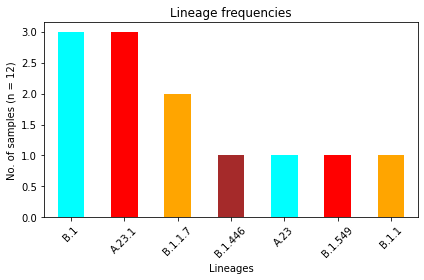

In [39]:
# plot lineage frequencies
colors = ['#00FFFF', '#FF0000', '#FFA500', '#A52A2A']
n = df_vnpPmd_fnl[df_vnpPmd_fnl['LIN'].isna() == False]['LIN'].count()
fig, ax = plt.subplots()
(df_vnpPmd_fnl[df_vnpPmd_fnl['LIN'].isna() == False]['LIN']
 .value_counts()
 .plot(kind='bar', ax=ax, color=colors))
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.xticks(rotation=45)
plt.ylabel(f'No. of samples (n = {n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P003.png', dpi=300.0)
plt.show()